
# Unified Silhouette Pipeline (HDR Coverage + Point-Fraction)

This notebook unifies both pipelines into one workflow with shared preprocessing

- `hdr` — *coverage mass on a float density field* (bootstrapped & smoothed) → mass-threshold isocontour.
- `point_fraction` — *densest subset of points (top p% by KDE)* → rasterized binary mask → contour.

TODO: 
- Add function to extract the curves to plot in d3
- add function to extract the oriented points

In [1]:
# silhouette_analysis_hdr_point_frac.py
# Minimal, dependency-light core that runs HDR and/or PF given two CSVs + optional configs.

# imports
from __future__ import annotations
import os, json, math, itertools
from dataclasses import dataclass, asdict, field
from typing import Tuple, Dict, List, Optional, TypedDict, Literal

import numpy as np
import pandas as pd

from scipy.ndimage import gaussian_filter, binary_closing, binary_opening, binary_fill_holes
from scipy.ndimage import label as _label
from scipy.spatial import cKDTree
from skimage.measure import find_contours
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import pdist

import matplotlib.pyplot as plt

# Config with default values
# pipeline will use these values unless other values are provided in the main function
# ---------------------------- Public Configs ----------------------------
@dataclass
class CfgCommon:
    grid_base: int = 160
    pad_frac: float = 0.05
    # Alignment (PCA + robust ICP)
    # fraction of worst matches to ignore in each ICP iteration
    # at most 0.5 (0.0 = use all points)
    trim_q: float = 0.10
    # number of ICP iterations
    # error usually stabilizes after ~20
    icp_iters: int = 30 # use ~50 for more difficult cases
    # max points to sample from each set for ICP (None = use all)
    sample_icp: int = 50000
    out_dir: str = "out_unified_core"

@dataclass
class CfgHDR:
    # Bootstrap for density averaging
    n_boot: int = 256
    sample_frac: float = 1.0 # draw n with replacement if 1.0
    # 2D density smoothing (pixels of the 2D hist grid)
    sigma_px: float = 1.2
    # Tail trimming for HDR (zeros tiny densities before threshold search)
    density_floor_frac: float = 0.002
    # Coverage (HDR) levels
    mass_levels: Tuple[float, ...] = (1.00, 0.99, 0.98, 0.97, 0.96, 0.95, 0.90, 0.80, 0.60, 0.50)
    # reproducibility control for bootstrap
    rng_seed: int = 0

@dataclass
class CfgMorph:
    closing: int = 1
    opening: int = 1
    keep_largest: bool = True
    fill_holes: bool = True
    
@dataclass
class CfgPF:
    frac_levels: Tuple[float, ...] = (1.00, 0.99, 0.98, 0.97, 0.96, 0.95, 0.90, 0.80, 0.60, 0.50)
    bandwidth: Optional[float] = None
    disk_px: int = 2
    # expose morphology controls to the user
    morph: CfgMorph = field(default_factory=CfgMorph)

# ---------------------------- Public Types ----------------------------
Plane = Literal["XY", "YZ", "XZ"]
Variant = Literal["hdr", "point_fraction"]

class ShapeProduct(TypedDict):
    plane: Plane
    level: int              # 50,60,80,95,100
    variant: Variant
    mask: np.ndarray        # bool [ny, nx]
    contour: Optional[np.ndarray]  # [N,2] (row, col)

class RunResult(TypedDict):
    A: np.ndarray           # aligned & scaled 3D points (N,3)
    B: np.ndarray
    shapes: Dict[Variant, Dict[Plane, Dict[int, Tuple[ShapeProduct, ShapeProduct]]]]
    metrics: pd.DataFrame   # columns: plane, level, variant, IoU, meanNN, Hausdorff
    meta: dict
    background: Dict[Plane, np.ndarray]  # union-of-points mask per plane (bool [ny,nx])
    densities: Optional[Dict[str, Dict[Plane, np.ndarray]]]  # None if HDR not run; else {'A':{plane:D}, 'B':{...}}
    projections: Dict[Plane, Dict[str, np.ndarray]]  # {"XY":{"xs","ys","A2","B2"}, ...}

# ---------------------------- IO ----------------------------
def load_points(csv: str, cols: Tuple[str,str,str]=("middle_x","middle_y","middle_z")) -> np.ndarray:
    """
    Load 3D points from CSV using provided column names (default to our current data's middle_x/y/z).
    """
    df = pd.read_csv(csv)
    for c in cols:
        if c not in df.columns:
            raise ValueError(f"Column '{c}' not found in {csv}. Available: {list(df.columns)[:12]}...")
    P = df[list(cols)].dropna().values.astype(np.float32)
    if len(P) < 50:
        raise ValueError(f"Too few points in {csv} after dropna on {cols}")
    return P

# ---------------------------- Alignment ----------------------------
def pca_axes(pts: np.ndarray):
    C = np.cov((pts - pts.mean(0)).T)
    w, V = np.linalg.eigh(C)
    V = V[:, np.argsort(w)[::-1]] # sort eigenvectors by descending eigenvalues
    if np.linalg.det(V) < 0:
        V[:, -1] *= -1 # enforce right-handedness
    return V

def nn_metrics(A_pts, B_pts):
    ta, tb = cKDTree(A_pts), cKDTree(B_pts)
    dBA,_ = ta.query(B_pts, k=1); dAB,_ = tb.query(A_pts, k=1) # distance from each B to nearest A and vice versa
    rmse = float(np.sqrt((np.concatenate([dBA, dAB])**2).mean())) 
    return rmse

# Find the best PCA-based alignment (rotation matrix) of B onto A
# by testing all axis permutations & sign flips, keeping the one with lowest RMSE.
def best_pca_prealign(B_pts, A_pts):
    # get PCA axes
    Va, Vb = pca_axes(A_pts), pca_axes(B_pts)
    perms = list(itertools.permutations(range(3)))
    signs = list(itertools.product([1,-1], repeat=3))
    # identity matrix
    best_R, best_rmse = np.eye(3), np.inf
    for p in perms:
        P = np.zeros((3,3)); P[range(3), list(p)] = 1
        for s in signs:
            S = np.diag(s)
            # Orthogonal Procrustes Problem
            R = Va @ (P @ S) @ Vb.T
            rmse = nn_metrics(A_pts, B_pts @ R.T)
            if rmse < best_rmse:
                best_rmse, best_R = rmse, R
    return best_R

# Kabsch rigid alignment from point set Q-->P (compute rotation + translation).
# Note: this implementation returns a transform used later as Q @ R.T + t.
# See https://en.wikipedia.org/wiki/Kabsch_algorithm
# given two sets of paired points P and Q
# Kabsch finds the best rotation R and translation t that makes them overlap as closely as possible
# it does without scaling so distances and shapes stay the same
def kabsch(P, Q):
    # center both sets of points at the origin
    Pc, Qc = P.mean(0), Q.mean(0)
    P0, Q0 = P - Pc, Q - Qc
    # compute covariance matrix
    H = Q0.T @ P0
    # SVD = Singular Value Decomposition
    U, S, Vt = np.linalg.svd(H)
    # compute rotation
    R = Vt.T @ U.T
    # ensure a right-handed coordinate system (no reflection)
    if np.linalg.det(R) < 0:
        # flip the last singular vector
        Vt[-1,:] *= -1; R = Vt.T @ U.T
    # compute translation
    t = Pc - Qc @ R.T
    return R, t

def icp_rigid_robust(A_pts, B_pts, iters=30, sample=50000, trim_q=0.10, seed=11):
    # random number generator
    rs = np.random.default_rng(seed)
    # if sample <= len(pts), use all points
    # else randomly sample without repeat (each points can only be chosen once)
    A = A_pts if len(A_pts)<=sample else A_pts[rs.choice(len(A_pts), sample, replace=False)]
    B = B_pts if len(B_pts)<=sample else B_pts[rs.choice(len(B_pts), sample, replace=False)]
    
    # identity matrix for rotation, zero vector for translation
    R, t = np.eye(3), np.zeros(3)
    for _ in range(iters):
        # Apply the current transform
        Bx = B @ R.T + t
        # Find nearest neighbors
        tree = cKDTree(A); d, idx = tree.query(Bx, k=1)
        P = A[idx]
        # Discard a fraction of worst matches (trim outliers)
        if 0.0 < trim_q < 0.5:
            # keep only the best (1-trim_q) fraction of matches
            thr = np.quantile(d, 1 - trim_q)
            # build a mask of which matches to keep (True/False)
            keep = d <= thr
            # apply the mask
            P, Bx = P[keep], Bx[keep]
        # compute optimal rigid transform on the remaining matches
        # we have P (from A) and Bx (transformed B) pairs
        # we need to find best rotation + shift that brings B onto A
        R_upd, t_upd = kabsch(P, Bx)
        # update the overall transform (order matters!)
        # combine new rotation with previous rotation
        R = R_upd @ R
        t = (t @ R_upd.T) + t_upd
    return R, t

# ---------------------------- Grid / Planes ----------------------------
PLANE_FROM_AXIS = {'z': 'XY', 'x': 'YZ', 'y': 'XZ'}
AXPAIR = {'z': (0,1), 'x': (1,2), 'y': (0,2)}

def make_grid_from_bounds(P: np.ndarray, base=160, pad_frac=0.05):
    # find min and max along each axis (x, y, z)
    # This gives the bounding box of all points P
    mn, mx = P.min(0), P.max(0)
    # Compute the extent = size of the box in each dimension
    ext = mx - mn
    # add padding, expand both min and max by this pad amount
    pad = pad_frac * float(ext.max()); mn -= pad; mx += pad; ext = mx - mn
    # decide how finely to scale the grid
    # base = target size of the longest axis (e.g. 160)
    scale = base / float(ext.max() + 1e-8)
    # compute the number of bins (voxels) along each axis
    # clamp to [32, 512] to avoid too coarse or too fine grids
    dims = np.clip(np.ceil(ext * scale).astype(int), 32, 512)
    # compute the bin edges along each axis
    edges = [np.linspace(mn[i], mx[i], dims[i] + 1, dtype=np.float32) for i in range(3)]
    return edges, dims

def grid_centers_from_edges(ex, ey):
    # Number of pixels along X and Y for this plane.
    # Convert bin edges into number of bins (pixels). If edges have length N+1, there are N bins.
    # The raster mask needs exact dimensions
    nx = len(ex) - 1; ny = len(ey) - 1
    # Create arrays of pixel center coordinates along X and Y.
    # When rasterizing points, we need to know where pixel centers are to place each point in the right bin.
    xs = np.linspace(ex[0], ex[-1], nx)
    ys = np.linspace(ey[0], ey[-1], ny)
    return xs, ys

# Projects a 3D point set P onto a 2D plane by dropping one axis.
def project_plane(P: np.ndarray, axis: str) -> np.ndarray:
    # The dictionary maps the dropped axis ('x', 'y', or 'z') to the two axes to keep.
    d = {'x': [1,2], 'y': [0,2], 'z': [0,1]}[axis]
    # P[:, d] slices columns to keep just those two coordinates.
    return P[:, d]

def rasterize_points(points2d: np.ndarray, xs, ys, disk_px=2) -> np.ndarray:
    """Rasterize points to a binary mask with small disks (radius=disk_px pixels).
    Takes 2D points and turns them into a pixel grid (mask).
    """
    # get the height (ny) and width (nx) of the image grid
    ny, nx = len(ys), len(xs)
    # initialize a binary image of size (ny, nx) with all set to False
    img = np.zeros((ny, nx), dtype=bool)
    # create an array of integer offset values from -disk_px to +disk_px
    rr = np.arange(-disk_px, disk_px+1)
    # build 2D grids of x and y offsets covering the square
    XX, YY = np.meshgrid(rr, rr, indexing='xy')
    # create a boolean mask of the circle (disk)
    # for each square check if x^2 + y^2 is within the radius squared
    # True for pixels inside the disk, False outside
    disk = (XX**2 + YY**2) <= (disk_px**2)
    # half-height and half-width of the disk
    dh, dw = disk.shape[0]//2, disk.shape[1]//2
    # convert each point's (x,y) coordinates to pixel indices
    # np.searchsorted finds the index where each point would fit in the sorted xs/ys
    # subtract 1 to get the pixel to the left/below the point
    # clip to ensure indices are within image bounds [0, nx-1] or [0, ny-1]
    x_idx = np.clip(np.searchsorted(xs, points2d[:,0]) - 1, 0, nx-1)
    y_idx = np.clip(np.searchsorted(ys, points2d[:,1]) - 1, 0, ny-1)
    # loop over each point's pixel index
    for y, x in zip(y_idx, x_idx):
        # compute the bounding box of the disk, clipped to image boundaries
        # Makes sure the disk doesn’t go outside the image array.
        y0, y1 = max(0, y-dh), min(ny, y+dh+1)
        x0, x1 = max(0, x-dw), min(nx, x+dw+1)
        # adjust the starting index inside the disk mask when part of the disk if clipped
        # If the disk goes off the edge, we can’t take the full mask
        # we need to slice it starting further in.
        dy0 = 0 if y0==y-dh else (y-dh - y0)
        dx0 = 0 if x0==x-dw else (x-dw - x0)
        # Overlay the disk on the image.
        # |= means logical OR — so if any disk covers a pixel, that pixel becomes True.
        # The slices [dy0:…] and [dx0:…] ensure we only take the part of the disk mask that fits inside the image.
        # This step “paints” the disk onto the raster mask.
        img[y0:y1, x0:x1] |= disk[dy0:dy0+(y1-y0), dx0:dx0+(x1-x0)]
    return img

# ---------------------------- Common metrics ----------------------------
# Metrics 
# Intersection-over-Union (IoU) for boolean masks
def iou_bool(A: np.ndarray, B: np.ndarray) -> float:
    # if either is None or empty, return NaN
    inter = np.logical_and(A,B).sum()
    union = np.logical_or(A,B).sum()
    return float(inter) / float(union + 1e-9)

# Contour distances (mean nearest neighbor + Hausdorff)
# using cKDTree for fast nearest neighbor search
def contour_distances(CA: Optional[np.ndarray], CB: Optional[np.ndarray]) -> Tuple[float,float]:
    if CA is None or CB is None: return float('nan'), float('nan')
    TA, TB = cKDTree(CA), cKDTree(CB)
    da,_ = TA.query(CB, k=1); db,_ = TB.query(CA, k=1)
    return float((da.mean()+db.mean())/2.0), float(max(da.max(), db.max()))

# find contour from boolean mask
def contour_from_bool(M: np.ndarray) -> Optional[np.ndarray]:
    if M is None or M.sum() == 0: return None
    # find contours at level 0.5 (between False=0 and True=1)
    cs = find_contours(M.astype(float), level=0.5)
    if not cs: return None
    # return the longest contour
    cs.sort(key=lambda c: c.shape[0], reverse=True)
    return cs[0]

# ---------------------------- HDR ----------------------------
# Density thresholding & contours
def apply_density_floor(D: np.ndarray, frac: float) -> np.ndarray:
    # zero out tiny densities below a fraction of the max density
    if frac <= 0: return D
    # fraction of max density
    eps = float(frac) * float(D.max() if np.isfinite(D.max()) else 0.0)
    # if the fraction is too small, return the original array
    if eps <= 0: return D
    # otherwise zero out values below eps
    Df = D.copy()
    Df[Df < eps] = 0.0
    return Df

def mass_threshold(D: np.ndarray, mass: float) -> float:
    """
    Return density threshold (tau) so that sum(D[D>=tau]) ≈ mass * sum(D).
    Special-case mass=1.0 -> choose the smallest strictly positive tau to include all positive density.
    """
    # make density map 1-D so its easy to sort and sum
    flat = D.ravel()
    # total density in the map
    # if zero/negative/NaN, return inf
    s = flat.sum()
    if s <= 0: return float('inf')
    # special case for p100 : take the smallest positive density value
    # so that all positive density is included
    # if no positive values, return inf
    if mass >= 0.999999:
        pos = flat[flat > 0]
        return float(pos.min()) if pos.size else float('inf')
    # sort densities in descending order (highest to lowest)
    v = np.sort(flat)[::-1]
    # cumulative sum of sorted densities
    c = np.cumsum(v)
    # target total = mass * (total density)
    # find the smallest index where cumulative sum >= target total
    # return the density value at that index as the threshold
    return float(v[np.searchsorted(c, mass * c[-1], side='left')])

# find contour at given mass level
def contour_at_mass(D: np.ndarray, mass: float) -> Optional[np.ndarray]:
    # get the cutoff tau, if tau is inf or NaN, return None
    tau = mass_threshold(D, mass)
    if not np.isfinite(tau): return None
    # Use skimage.measure.find_contours to trace level-tau isolines on the 2D array.
    # returns a list of polylines (each is [N,2] as [row,col])
    cs = find_contours(D, level=tau)  # D is [rows, cols]
    # if no contours found, return None
    if not cs: return None
    # Sort by number of points (proxy for length) and keep the longest contour (main silhouette).
    cs.sort(key=lambda c: c.shape[0], reverse=True)
    return cs[0]

# Bootstrap 2D densities
# resample points many times with replacement
# smooth them onto the shared grid to see where points consistently fall
# from this probability map extract regions that are always there (high-density contours)
def boot_density_2d(P: np.ndarray, edges3d, n_boot=256, sample_frac=1.0, sigma_px=1.2, rng_seed: int = 0):
    """
    Average 2D densities over bootstrap resamples.
    Returns a dict: Densities 'x|y|z' -> [ny,nx] float
    """
    # which 2D plane corresponds to which axes
    xed, yed, zed = edges3d
    plane_edges = {'z': (xed, yed), 'x': (yed, zed), 'y': (xed, zed)}
    # accumulators for density sums
    accD = {a: None for a in ('x','y','z')}
    # number of points to sample in each bootstrap resample
    n = len(P); k = max(1, int(round(sample_frac * n)))
    # random number generator
    rs = np.random.default_rng(rng_seed)
    
    for _ in range(n_boot):
        # pick k points with replacement
        idx = rs.integers(0, n, size=k) # with replacement
        sub = P[idx]
        for a in ('x','y','z'):
            # take two coords indices
            i, j = AXPAIR[a]
            ex, ey = plane_edges[a]
            # 2D histogram
            H, _, _ = np.histogram2d(sub[:, i], sub[:, j], bins=[ex, ey]) # shape [nx, ny]
            # density (smoothed) gaussian filter
            D = gaussian_filter(H.astype(np.float32), sigma=sigma_px)
            # transpose to standard orientation [rows, cols] = [y, x]
            D = D.T # -> [ny, nx]
            if accD[a] is None: accD[a] = D
            else: accD[a] += D

    # average density maps across bootstraps
    outD = {a: (accD[a] / float(n_boot)) if accD[a] is not None else None for a in accD}
    return outD

def make_hdr_shape(D: np.ndarray, plane: Plane, mass: float, density_floor_frac: float) -> ShapeProduct:
    # densities with floor (for nicer HDR contours)
    Df = apply_density_floor(D, density_floor_frac)
    # Find the density cutoff (tau) for A and B that encloses m × 100% of the mass.
    tau = mass_threshold(Df, mass)
    # Turn the density maps into binary masks 
    mask = (Df >= tau)
    # Extract the contour lines (the actual silhouette boundaries).
    contour = contour_at_mass(Df, mass)
    return dict(plane=plane, level=int(round(mass*100)), variant="hdr", mask=mask, contour=contour)

# ---------------------------- Point-Fraction ----------------------------
def kde_scores(points2d: np.ndarray, bandwidth: float) -> np.ndarray:
    """Gaussian KDE score per point (log-density up to constant).
    We’re computing per-point density scores using Gaussian kernel density estimation (KDE). 
    The output is log-density (up to an additive constant), which is perfect for ranking points by crowdedness.
    """
    # If there are fewer than 2 points, return zeros. KDE needs at least 2 points to compute density.
    if points2d.shape[0] < 2:
        return np.zeros(points2d.shape[0])
    # Build and fit a KDE model with the specified bandwidth
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(points2d)
    # Compute the log-density at each data point
    # We only need relative order (who’s denser than whom), 
    # so log-density is ideal and numerically stable.
    return kde.score_samples(points2d)

def _scott_bandwidth(points2d: np.ndarray) -> float:
    # Scott's rule on 2D: h ~ n^(-1/(d+4)) times std; use median distance fallback if degenerate
    n = max(2, points2d.shape[0]); d = 2
    std = np.std(points2d, axis=0).mean() or 1.0
    return max(1e-6, std * (n ** (-1.0/(d+4))))
    
# Pick a data-driven KDE bandwidth when the user doesn’t specify one.
def auto_bandwidth(points2d: np.ndarray, strategy: str = "median*0.5") -> float:
    """
    strategy E {"median*0.5","scott"}
    """
    # Count points to decide subsampling and edge cases.
    N = points2d.shape[0]
    # If there are 0 or 1 points, return a default bandwidth of 1.0.
    if N <= 1:
        return 1.0
    if strategy == "scott":
        return _scott_bandwidth(points2d)
    # For large datasets, subsample 500 points without replacement.
    # Computing all pairwise distances scales as O(N^2)
    # subsampling keeps this step fast while still representative.
    if N > 500:
        idx = np.random.choice(N, size=500, replace=False)
        samp = points2d[idx]
    else:
        samp = points2d
    # Compute the median pairwise distance between sampled points.
    md = np.median(pdist(samp)) if samp.shape[0] >= 2 else 1.0
    # Heuristic bandwidth = half the median distance, clamped to a tiny positive minimum.
    return max(1e-6, md * 0.5)

def point_fraction_mask(points2d: np.ndarray,
                        xs, ys,
                        frac: float,
                        bandwidth: Optional[float],
                        disk_px: int,
                        morph: Optional[CfgMorph]=None) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Binary mask enclosing the top ceil(frac*N) points by local density.
    Returns (mask, kept_points2d, bandwidth_used).
    """
    # use-defined morph config or default
    morph = morph or CfgMorph()
    # Count total points
    N = points2d.shape[0]
    # Compute the number of points to keep: k = ceil(f × N), but at least 1.
    k = max(1, int(math.ceil(frac * N)))
    # Choose KDE bandwidth: use provided value or auto-estimate from the data.
    # KDE needs a scale; auto keeps things robust across datasets.
    bw = auto_bandwidth(points2d, strategy="median*0.5") if bandwidth is None else bandwidth
    # Compute a density (crowdedness) score per point via KDE.
    # We want to rank points by how densely they sit among neighbors, so outliers get low scores.
    scores = kde_scores(points2d, bandwidth=bw)
    # Get indices that sort points descending by density score.
    # Highest scores first = densest points first.
    order = np.argsort(scores)[::-1]
    # Slice the first k indices = densest k points.
    keep_idx = order[:k]
    # Extract those densest points.
    # We’ll rasterize only these and also return them for audit (len(kept) should equal k).
    kept = points2d[keep_idx]
    
    # Draw the kept points as small disks on the shared grid to create a raw boolean mask.
    # Converts scattered points into a contiguous region suitable for cleanup/contouring
    mask = rasterize_points(kept, xs, ys, disk_px=disk_px)
    if morph.closing > 0:
        # Morphological closing to seal tiny gaps and connect near pixels.
        # Prevents hairline breaks in the region.
        mask = binary_closing(mask, iterations=morph.closing)
    if morph.opening > 0:
        # Morphological opening to remove small specks/outliers.
        # Removes tiny noise pixels.
        mask = binary_opening(mask, iterations=morph.opening)
    if morph.keep_largest:
        # Keep only the largest connected region and fill holes.
        # Ensures a single solid silhouette.
        mask = biggest_component_mask(mask, fill_holes=morph.fill_holes)
    elif morph.fill_holes:
        # Fill holes in all components (rarely needed; keep_largest is typical)
        mask = binary_fill_holes(mask)
    
    return mask, kept, bw

def biggest_component_mask(mask: np.ndarray, fill_holes: bool = True) -> np.ndarray:
    """
    Cleans a binary mask by keeping only the largest connected component and filling any holes in it.
    This produces a solid silhouette.
    It keeps only the largest connected blob (so small specks or stray fragments are removed).
    It then fills any holes inside that blob (so you get a solid region instead of a donut).
    The result is a clean silhouette mask that’s stable and interpretable.
    """
    # if the mask is empty, return it as is
    if mask.sum() == 0:
        return mask

    # label scans the mask and assigns a unique number to each connected blob of True pixels.
    # We need to know how many blobs exist, so we can keep the biggest one
    labeled_mask, num_features = _label(mask)
    if num_features == 0:
        return np.zeros_like(mask)

    # Count how many pixels belong to each label. 
    # Index 0 = background, 1+ = real blobs. 
    # If only background exists, return an empty mask.
    # This step avoids returning junk when there’s no real component.
    component_sizes = np.bincount(labeled_mask.ravel())
    if len(component_sizes) <= 1: # Only background found
        return np.zeros_like(mask)

    # Find the label of the largest blob (biggest pixel count). 
    # Adds +1 because we skipped background when indexing.
    # Ensures we only keep the main silhouette, not specks
    # Ignore component 0 (background)
    largest_component_label = np.argmax(component_sizes[1:]) + 1
    
    # Build a new mask that keeps only the largest blob. Everything else is set to False.
    # Removes noise and isolates the silhouette we care about.
    largest_component = (labeled_mask == largest_component_label)
    # Fill internal holes inside the blob. Turns donut-like shapes into solid regions.
    # Ensures a consistent, interpretable outline.
    solid_mask = binary_fill_holes(largest_component) if fill_holes else largest_component
    return solid_mask

def make_pf_shape(points2d: np.ndarray,
                  xs,
                  ys, 
                  plane: Plane, 
                  frac: float,
                  bandwidth: Optional[float], 
                  disk_px: int, 
                  morph: Optional[CfgMorph]=None) -> ShapeProduct:
    """ INPUT: 
        points2d: the 2D projected points for one condition (A or B) on this plane.
        xs, ys: the shared grid’s pixel-center coordinates (so masks line up across A/B).
        plane: 
        frac: the target fraction (e.g., 0.5, 0.8, 1.0).
        bandwidth: KDE bandwidth (or None to auto-pick).
        disk_px: disk radius in pixels used when rasterizing kept points.
        OUTPUT: 
        contour: the main contour (Nx2 array of [row, col] coordinates) or None if no contour,
        mask: the cleaned boolean mask for this fraction,
        kept: the actual subset of points retained by the fraction rule (densest ceil(frac×N)).
    """
    # build the fraction mask and get the kept points
    mask, kept, bw = point_fraction_mask(points2d, xs, ys, frac, bandwidth, disk_px, morph=morph)
    # Extract the main contour from the boolean mask
    contour = contour_from_bool(mask)
    return dict(plane=plane, level=int(round(frac*100)), variant="point_fraction", mask=mask, contour=contour)

# ---------------------------- Orchestration ----------------------------
def _align_scale_and_grid(A_raw: np.ndarray, B_raw: np.ndarray, cfg: CfgCommon):
    # center both at 0, 0, 0
    # mean(0) -> avg each column
    A0, B0 = A_raw - A_raw.mean(0), B_raw - B_raw.mean(0)
    # 2) align B->A (best-PCA, then ICP)
    Rpre = best_pca_prealign(B0, A0)
    # apply pre-align
    B1 = B0 @ Rpre.T
    # refine with robust ICP
    # TODO: may not needed for our case
    # TODO: how to identify the appropiate sample size? 
    Ricp, ticp = icp_rigid_robust(A0, B1, iters=cfg.icp_iters, sample=cfg.sample_icp, trim_q=cfg.trim_q)
    # apply ICP
    A_al, B_al = A0, (B1 @ Ricp.T + ticp)
    # 3) uniform scale (shared bbox)
    # minimum and maximum XYZ across both sets
    mins = np.vstack([A_al, B_al]).min(0); maxs = np.vstack([A_al, B_al]).max(0)
    # Compute the size of that bounding box along each axis
    s = float((maxs - mins).max())
    # Divide all coordinates by s
    # this scales both point clouds into the same unit cube
    # fits within [-1,1] or [0,1], depending on origin
    A = A_al/s; B = B_al/s
     # 4) shared 3D grid (for consistent 2D edges)
    # creates a global 3D grid that fits both sets of points
    edges3d, _ = make_grid_from_bounds(np.vstack([A, B]), base=cfg.grid_base, pad_frac=cfg.pad_frac)
    return A, B, edges3d

def _per_plane_points(A: np.ndarray, B: np.ndarray, edges3d) -> Dict[Plane, Dict[str, np.ndarray]]:
    out = {}
     # loop over three projections
    for a in ('x','y','z'):
        # which plane (e.g., 'z' → "XY", 'y' → "XZ", `'x' → "YZ"'
        plane: Plane = PLANE_FROM_AXIS[a]  # type: ignore
        # which two axes to use (e.g., 'z' → (0,1) for X and Y)  
        # Needed to slice the point arrays correctly (A[:, [i, j]]).
        i, j = AXPAIR[a]
        # Pull out the grid edges along the chosen axes from the global 3D grid.
        #Ensures both conditions (A and B) rasterize onto the same pixel grid, making IoU and distance metrics valid.
        ex, ey = edges3d[i], edges3d[j]
        xs, ys = grid_centers_from_edges(ex, ey)
        # Project the 3D aligned points (A and B) into 2D by keeping only the chosen two axes.
        # The rest of the pipeline (KDE ranking, rasterization, mask cleaning, contour extraction) works in 2D.
        out[plane] = dict(xs=xs, ys=ys, A2=A[:,[i,j]], B2=B[:,[i,j]])
    return out

# function to compute and append metrics for a given plane, level, and variant
def _append_metrics(rows: List[dict], plane: Plane, level: int, variant: Variant,
                    MA: np.ndarray, MB: np.ndarray, CA: Optional[np.ndarray], CB: Optional[np.ndarray]):
    # calls iou_bool to compute Intersection-over-Union (IoU) for the two boolean masks
    IoU = iou_bool(MA, MB)
    # calls contour_distances to compute mean nearest neighbor and Hausdorff distances between the two contours
    mnn, haus = contour_distances(CA, CB)
    # append a dict with all info to rows
    rows.append(dict(plane=plane, level=level, variant=variant, IoU=IoU, meanNN=mnn, Hausdorff=haus))

# main function to run silhouette analysis
# takes two CSV files and optional configs
# toggle HDR and PF computations
# returns a RunResult with shapes and metrics
def run_silhouettes(csv_A: Optional[str] = None,
                    csv_B: Optional[str] = None,
                    *,
                    A_points: Optional[np.ndarray] = None,
                    B_points: Optional[np.ndarray] = None,
                    xyz_cols: Tuple[str,str,str] = ("middle_x","middle_y","middle_z"),
                    out_dir: Optional[str] = None,
                    run_hdr: bool = True,
                    run_pf: bool = True,
                    cfg_common: Optional[CfgCommon] = None,
                    cfg_hdr: Optional[CfgHDR] = None,
                    cfg_pf: Optional[CfgPF] = None,
                    planes: Tuple[Plane, ...] = ("XY","YZ","XZ")) -> RunResult:
    """Entrypoint: pass CSVs with xyz_cols OR pass A_points/B_points arrays."""
    # Prepare configs and output directory
    # use defaults if not provided
    cfg_common = cfg_common or CfgCommon()
    # override output dir if given
    if out_dir: cfg_common.out_dir = out_dir
    # HDR and PF configs; use defaults if not provided
    cfg_hdr = cfg_hdr or CfgHDR()
    cfg_pf = cfg_pf or CfgPF()
    # make sure output dir exists
    os.makedirs(cfg_common.out_dir, exist_ok=True)

    # Load & preprocess
    if A_points is not None and B_points is not None:
        A_raw, B_raw = A_points.astype(np.float32), B_points.astype(np.float32)
        csv_A = csv_A or "<ndarray>"
        csv_B = csv_B or "<ndarray>"
    elif csv_A and csv_B:
        A_raw = load_points(csv_A, cols=xyz_cols)
        B_raw = load_points(csv_B, cols=xyz_cols)
    else:
        raise ValueError("Provide either csv_A & csv_B (with xyz_cols) OR A_points & B_points arrays.")
    # pca pre-align, ICP, bounding box, shared grid
    A, B, edges3d = _align_scale_and_grid(A_raw, B_raw, cfg_common)
    # Precompute per-plane (XY, YZ, XZ) 2D projections & their bin edges for later steps
    # Typical contents: {plane: {"xs","ys","A2","B2"}}
    per_plane_all = _per_plane_points(A, B, edges3d)
    per_plane = {k: v for k, v in per_plane_all.items() if k in set(planes)}

    # Background masks (for plotting if needed)
    # Quick union-of-presence mask per plane (A ∪ B), using simple disk splats
    # Purely for visual context layers in figures (light gray “cloud”)
    background = {
        plane: (rasterize_points(d["A2"], d["xs"], d["ys"], disk_px=2) |
                rasterize_points(d["B2"], d["xs"], d["ys"], disk_px=2))
        for plane, d in per_plane.items()
    }

    # HDR compute
    # Initialize holders for HDR densities
    hdr_densA = hdr_densB  = None
    # For each plane, build smoothed bootstrap-averaged density maps
    # Parameters: number of resamples, subsample fraction, Gaussian blur width.
    if run_hdr:
        # 2D densities via bootstrap
        hdr_densA = boot_density_2d(A, edges3d,
            n_boot=cfg_hdr.n_boot, sample_frac=cfg_hdr.sample_frac,
            sigma_px=cfg_hdr.sigma_px, rng_seed=cfg_hdr.rng_seed)
        hdr_densB = boot_density_2d(B, edges3d,
            n_boot=cfg_hdr.n_boot, sample_frac=cfg_hdr.sample_frac,
            sigma_px=cfg_hdr.sigma_px, rng_seed=cfg_hdr.rng_seed)
        # Save raw densities for reuse
        for a in ('x','y','z'):
            plane = PLANE_FROM_AXIS[a]
            # densities (raw)
            # save as .npy for possible latder use
            if hdr_densA[a] is not None and hdr_densB[a] is not None:
                np.save(os.path.join(cfg_common.out_dir, f"density_A_{plane}.npy"), hdr_densA[a])
                np.save(os.path.join(cfg_common.out_dir, f"density_B_{plane}.npy"), hdr_densB[a])

    # Build shapes + metrics
    # shapes collects produced outlines/masks indexed by variant --> plane --> level.
    # rows accumulates metric rows (IoU, meanNN, Hausdorff) for a final DataFrame.
    shapes: Dict[Variant, Dict[Plane, Dict[int, Tuple[ShapeProduct, ShapeProduct]]]] = {}
    rows: List[dict] = []

    # HDR shapes
    # Only proceed if we computed HDR densities.
    if run_hdr and hdr_densA and hdr_densB:
        # Initialize HDR shapes dictionary
        shapes.setdefault("hdr", {})
        for a in ('x','y','z'):
            # which plane (e.g., 'z' → "XY", 'y' → "XZ", `'x' → "YZ"'
            plane: Plane = PLANE_FROM_AXIS[a]  # type: ignore
            # pull out the precomputed density maps for A and B on this plane
            D_A, D_B = hdr_densA[a], hdr_densB[a]
            # skip if either density map is missing
            if D_A is None or D_B is None: continue
            # for each requested mass level, build shapes and compute metrics
            shapes["hdr"].setdefault(plane, {})
            # loop over mass levels (fractions of total density)
            for m in cfg_hdr.mass_levels:
                # build HDR shapes for A and B at this mass level
                spA = make_hdr_shape(D_A, plane, m, cfg_hdr.density_floor_frac)
                spB = make_hdr_shape(D_B, plane, m, cfg_hdr.density_floor_frac)
                # store the shapes per plane/level
                shapes["hdr"][plane][spA["level"]] = (spA, spB)
                # compute and append metrics 
                _append_metrics(rows, plane, spA['level'], "hdr", spA['mask'], spB['mask'], spA['contour'], spB['contour'])

    # PF shapes
    if run_pf:
        # Initialize PF shapes dictionary
        shapes.setdefault("point_fraction", {})
        # for each plane, build PF shapes at requested fraction levels
        for plane, d in per_plane.items():
            # pull out the precomputed 2D projected points and grid for this plane
            xs, ys = d["xs"], d["ys"]; A2, B2 = d["A2"], d["B2"]
            # loop over requested fraction levels
            for frac in cfg_pf.frac_levels:
                # build PF shapes for A and B at this fraction level
                spA = make_pf_shape(A2, xs, ys, plane, frac, cfg_pf.bandwidth, cfg_pf.disk_px, morph=cfg_pf.morph)
                spB = make_pf_shape(B2, xs, ys, plane, frac, cfg_pf.bandwidth, cfg_pf.disk_px, morph=cfg_pf.morph)
                # store the shapes per plane/level
                shapes["point_fraction"].setdefault(plane, {})[spA["level"]] = (spA, spB)
                # compute and append metrics
                _append_metrics(rows, plane, spA['level'], "point_fraction", spA['mask'], spB['mask'], spA['contour'], spB['contour'])

    # Metrics + meta
    # compile metrics into a DataFrame and save as CSV
    metrics = pd.DataFrame(rows).sort_values(["plane","variant","level"], ascending=[True, True, False])
    # save metrics CSV
    metrics_path = os.path.join(cfg_common.out_dir, "metrics_unified.csv")
    metrics.to_csv(metrics_path, index=False)

    # save a JSON receipt with input files, configs, and planes processed
    # helpful for debugging and reproducibility
    meta = dict(csv_A=csv_A, csv_B=csv_B,
                cfg_common=asdict(cfg_common), cfg_hdr=asdict(cfg_hdr), cfg_pf=asdict(cfg_pf),
                planes=list(per_plane.keys()))
    with open(os.path.join(cfg_common.out_dir, "meta_unified.json"), "w") as f:
        json.dump(meta, f, indent=2)

    # Pack densities (optional)
    # provide density arrays in the output if HDR was run and densities exist
    # useful for visualizing density heatmaps alongside contours
    densities = None
    if run_hdr and hdr_densA and hdr_densB:
        densities = {
            'A': {PLANE_FROM_AXIS[a]: hdr_densA[a] for a in ('x','y','z') if hdr_densA[a] is not None},
            'B': {PLANE_FROM_AXIS[a]: hdr_densB[a] for a in ('x','y','z') if hdr_densB[a] is not None},
        }

    return dict(
        A=A, B=B,
        shapes=shapes,
        metrics=metrics,
        meta=meta,
        background=background,    
        densities=densities,
        projections=per_plane,
    )


In [2]:
# ============================= Visualization helpers (optional) =============================

# parse levels argument (int, list[int], or "all") into a tuple of ints
# ============================= Visualization helpers (optional) =============================

# parse levels argument (int, list[int], or "all") into a tuple of ints
def _levels_from_result(kind: str, cfg_hdr: CfgHDR, cfg_pf: CfgPF, levels):
    # supports int, list[int], or "all"
    if isinstance(levels, str) and levels.lower() == "all":
        if kind == "hdr":
            return tuple(sorted({int(round(p*100)) for p in cfg_hdr.mass_levels}, reverse=True))
        if kind == "point_fraction":
            return tuple(sorted({int(round(p*100)) for p in cfg_pf.frac_levels}, reverse=True))
    if isinstance(levels, (list, tuple, set, np.ndarray)):
        return tuple(int(x) for x in levels)
    if isinstance(levels, (int, float)):
        return (int(levels),)
    raise ValueError("levels must be int, list[int], or 'all'")

# simple overlay plot of two shapes on given axis
def _plot_overlay(ax, shapeA: ShapeProduct, shapeB: ShapeProduct, bg: np.ndarray, title: str, labelA="A", labelB="B"):
    if bg is not None:
        ax.imshow(bg, cmap="gray", alpha=0.12)
    if shapeA.get("contour") is not None:
        C = shapeA["contour"]
        ax.plot(C[:,1], C[:,0], '-', lw=2.4, color="#1f77b4", alpha=0.95,
                label=f"{labelA} {shapeA['variant']} {shapeA['level']}%")
    if shapeB.get("contour") is not None:
        C = shapeB["contour"]
        ax.plot(C[:,1], C[:,0], '-', lw=2.4, color="#d62728", alpha=0.95,
                label=f"{labelB} {shapeB['variant']} {shapeB['level']}%")
    ax.set_title(title); ax.set_axis_off(); ax.legend(frameon=False, loc="upper right")

def view(result: RunResult,
         kind: Literal["hdr","point_fraction"] = "hdr",
         plane: Plane = "XY",
         levels: "int|list[int]|str" = "all",
         *,
         labelA: str = "A",
         labelB: str = "B",
         show_heat: bool = False,
         cfg_hdr: Optional[CfgHDR] = None,
         cfg_pf: Optional[CfgPF] = None):
    """
    Quick viewer for shapes produced by run_silhouettes().
    - kind: 'hdr' | 'point_fraction'
    - plane: 'XY' | 'YZ' | 'XZ'
    - levels: int | list[int] | 'all'
    - show_heat: if True and kind='hdr' and densities exist, show A's density heat under contours.
    """
    cfg_hdr = cfg_hdr or CfgHDR()
    cfg_pf  = cfg_pf  or CfgPF()
    lvls = _levels_from_result(kind, cfg_hdr, cfg_pf, levels)

    if kind not in result["shapes"]:
        print(f"[view] No shapes for kind='{kind}'. Did you run with run_{kind}=True?")
        return

    shapes_kind = result["shapes"][kind]
    if plane not in shapes_kind:
        print(f"[view] No shapes for plane '{plane}' and kind '{kind}'.")
        return

    shapes_by_plane = shapes_kind[plane]  # dict: level -> (spA, spB)

    # figure
    fig, axes = plt.subplots(1, len(lvls), figsize=(5.4*len(lvls), 5.2))
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]

    # density heat if available (A only, for context)
    D_A_plane = None
    if show_heat and kind == "hdr" and result.get("densities") and result["densities"].get("A"):
        D_A_plane = result["densities"]["A"].get(plane)

    for ax, lvl in zip(axes, lvls):
        pair = shapes_by_plane.get(lvl)
        if pair is None:
            ax.text(0.5, 0.5, f"No {kind} {lvl}%", ha="center", va="center"); ax.axis("off"); continue
        spA, spB = pair
        bg = result["background"].get(plane)
        if D_A_plane is not None:
            ax.imshow(D_A_plane, alpha=0.35)  # faint heat underlay
        _plot_overlay(ax, spA, spB, bg, f"{plane} — {kind} {lvl}%", labelA, labelB)
    plt.tight_layout(); plt.show()

def save_figures(result: RunResult,
                 kind: Literal["hdr","point_fraction"] = "hdr",
                 plane: Plane = "XY",
                 levels: "int|list[int]|str" = "all",
                 *,
                 out_dir: str = "figures",
                 labelA: str = "A",
                 labelB: str = "B",
                 show_heat: bool = False,
                 cfg_hdr: Optional[CfgHDR] = None,
                 cfg_pf: Optional[CfgPF] = None):
    """
    Save per-plane overlays as PNGs for the selected kind/levels.
    Signature is consistent with `view()`.
    """
    os.makedirs(out_dir, exist_ok=True)
    cfg_hdr = cfg_hdr or CfgHDR()
    cfg_pf  = cfg_pf  or CfgPF()

    lvls = _levels_from_result(kind, cfg_hdr, cfg_pf, levels)
    if kind not in result["shapes"]:
        print(f"[save_figures] No shapes for kind='{kind}'.")
        return
    if plane not in result["shapes"][kind]:
        print(f"[save_figures] No shapes for plane='{plane}' and kind='{kind}'.")
        return

    shapes_by_plane = result["shapes"][kind][plane]

    # density heat if requested
    D_A_plane = None
    if show_heat and kind=="hdr" and result.get("densities") and result["densities"].get("A"):
        D_A_plane = result["densities"]["A"].get(plane)

    for lvl in lvls:
        pair = shapes_by_plane.get(lvl)
        if pair is None:
            continue
        spA, spB = pair
        bg = result["background"].get(plane)

        fig, ax = plt.subplots(figsize=(5.2,5.2))
        if D_A_plane is not None:
            ax.imshow(D_A_plane, alpha=0.35, cmap="inferno")
        _plot_overlay(ax, spA, spB, bg,
                      f"{plane} — {kind} {lvl}%",
                      labelA, labelB)

        fname = f"{kind}_{plane}_{lvl}.png"
        fig.savefig(os.path.join(out_dir, fname), dpi=200, bbox_inches="tight")
        plt.close(fig)

def view_projections(result: RunResult,
                     *,
                     planes: Tuple[Plane, ...] = ("XY","YZ","XZ"),
                     labelA: str = "A",
                     labelB: str = "B",
                     s: float = 3.0,
                     alphaA: float = 0.7,
                     alphaB: float = 0.7):
    """
    Show aligned point scatter plots for each plane.
    """
    proj = result.get("projections", {})
    if not proj:
        print("[view_projections] No projections in result.")
        return

    for plane in planes:
        if plane not in proj:
            print(f"[view_projections] No plane '{plane}' in projections.")
            continue
        A2 = proj[plane]["A2"]; B2 = proj[plane]["B2"]
        fig, ax = plt.subplots(figsize=(5.2, 5.2))
        ax.scatter(A2[:,0], A2[:,1], s=s, alpha=alphaA, label=labelA)
        ax.scatter(B2[:,0], B2[:,1], s=s, alpha=alphaB, label=labelB)
        ax.set_title(f"{plane} projection (aligned & scaled)")
        ax.set_xlabel(plane[0]); ax.set_ylabel(plane[1])
        ax.set_aspect("equal"); ax.legend(frameon=False)
        plt.show()

def save_projections(result: RunResult,
                     *,
                     out_dir: str = "figures",
                     planes: Tuple[Plane, ...] = ("XY","YZ","XZ"),
                     labelA: str = "A",
                     labelB: str = "B",
                     s: float = 3.0,
                     alphaA: float = 0.7,
                     alphaB: float = 0.7,
                     dpi: int = 220,
                     save_csv: bool = False):
    """
    Save aligned point scatter plots (and optionally CSVs) for each plane.
    """
    
    os.makedirs(out_dir, exist_ok=True)
    proj = result.get("projections", {})
    if not proj:
        print("[save_projections] No projections in result.")
        return

    for plane in planes:
        if plane not in proj:
            print(f"[save_projections] No plane '{plane}' in projections.")
            continue
        A2 = proj[plane]["A2"]; B2 = proj[plane]["B2"]

        fig, ax = plt.subplots(figsize=(5.2, 5.2))
        ax.scatter(A2[:,0], A2[:,1], s=s, alpha=alphaA, label=labelA)
        ax.scatter(B2[:,0], B2[:,1], s=s, alpha=alphaB, label=labelB)
        ax.set_title(f"{plane} projection (aligned & scaled)")
        ax.set_xlabel(plane[0]); ax.set_ylabel(plane[1])
        ax.set_aspect("equal"); ax.legend(frameon=False)
        fig.savefig(os.path.join(out_dir, f"projection_{plane}.png"),
                    dpi=dpi, bbox_inches="tight")
        plt.close(fig)

        if save_csv:
            base = os.path.join(out_dir, f"projection_{plane}")
            pd.DataFrame(A2, columns=[f"{plane[0]}", f"{plane[1]}"]).to_csv(base + "_A.csv", index=False)
            pd.DataFrame(B2, columns=[f"{plane[0]}", f"{plane[1]}"]).to_csv(base + "_B.csv", index=False)


In [2]:
# ============================= PURE-DATA EXPORTERS (D3 + THREE) =============================
# background mask
# contours
# densities
# projection
# points3D
# scales (bbox, mins)
# mata.json
# layout
# metrics


import os, json
from pathlib import Path
from typing import Dict, Tuple, Iterable, Optional
import numpy as np
from scipy.spatial import ConvexHull

def _ensure_dir(p: str):
    Path(p).mkdir(parents=True, exist_ok=True)

def _write_json(path: str, obj):
    with open(path, "w") as f:
        json.dump(obj, f, separators=(",", ":"), allow_nan=False, indent=2)

def _grid_sizes_from_result(result: RunResult) -> Dict[Plane, Tuple[int,int]]:
    # nx,ny from background masks (bool arrays are [ny, nx])
    return {plane: (bg.shape[1], bg.shape[0]) for plane, bg in result["background"].items()}

# ---------- Core ----------
def export_meta(result: RunResult, out_dir: str):
    _ensure_dir(out_dir)
    planes = list(result["background"].keys())
    grid = {p: list(_grid_sizes_from_result(result)[p]) for p in planes}
    labels = ["A", "B"]
    levels_hdr = []
    levels_pf = []
    if "hdr" in result["shapes"]:
        for plane in result["shapes"]["hdr"].keys():
            levels_hdr += list(result["shapes"]["hdr"][plane].keys())
    if "point_fraction" in result["shapes"]:
        for plane in result["shapes"]["point_fraction"].keys():
            levels_pf += list(result["shapes"]["point_fraction"][plane].keys())
    meta = dict(
        planes=planes,
        grid=grid,
        levels={"hdr": sorted(list(set(levels_hdr)), reverse=True),
                "pf":  sorted(list(set(levels_pf)),  reverse=True)},
        labels=labels,
    )
    _write_json(os.path.join(out_dir, "meta.json"), meta)

# ---------- D3: background-as-data ----------
def export_background_mask_json(result: RunResult, out_dir: str):
    _ensure_dir(out_dir)
    bg = {}
    for plane, arr in result["background"].items():
        # store as 0/1 (compact)
        bg[plane] = arr.astype(np.uint8).tolist()
    _write_json(os.path.join(out_dir, "background_mask.json"), bg)

def export_density_json(result: RunResult, out_dir: str, which: Iterable[str] = ("A","B")):
    """
    Writes density fields as nested lists (floats). Only if HDR was run.
    """
    if not result.get("densities"):
        return
    _ensure_dir(out_dir)
    for lab in which:
        if lab not in result["densities"]:
            continue
        payload = {plane: D.astype(float).tolist() for plane, D in result["densities"][lab].items()}
        _write_json(os.path.join(out_dir, f"density_{lab}.json"), payload)

# ---------- D3: contours (pixel coords) ----------
def export_contours_d3(result: RunResult, out_dir: str,
                       kind_levels: Dict[str, "int|Iterable[int]|str"] = {"hdr":"all","point_fraction":"all"},
                       labelA="A", labelB="B"):
    """
    contours_d3.json:
      { "contours": [ {plane, variant, level, label, points:[[x,y],...]} , ... ] }
    """
    _ensure_dir(out_dir)
    grid = _grid_sizes_from_result(result)
    out = dict(contours=[])
    cfg_hdr = CfgHDR(); cfg_pf = CfgPF()

    for kind, lv in kind_levels.items():
        if kind not in result["shapes"]:
            continue
        levels = _levels_from_result(kind, cfg_hdr, cfg_pf, lv)
        for plane, by_level in result["shapes"][kind].items():
            nx, ny = grid[plane]
            for level in levels:
                pair = by_level.get(level)
                if not pair: 
                    continue
                for label, sp in ((labelA, pair[0]), (labelB, pair[1])):
                    C = sp.get("contour")
                    if C is None: 
                        continue
                    # skimage contours are [row(y), col(x)] — convert to [x,y]
                    pts = [[float(c[1]), float(c[0])] for c in C]
                    out["contours"].append(dict(
                        plane=plane, variant="hdr" if kind=="hdr" else "pf",
                        level=int(level), label=label, points=pts
                    ))
    _write_json(os.path.join(out_dir, "contours_d3.json"), out)

# ---------- D3: 2D projections ----------
# def export_projections_json(result: RunResult, out_dir: str):
#     """
#     projections.json:
#       { "XY":{"A":[[x,y],...],"B":[[x,y],...]}, "YZ":{...}, "XZ":{...} }
#     """
#     _ensure_dir(out_dir)
#     payload = {}
#     for plane, d in result["projections"].items():
#         A2, B2 = d["A2"], d["B2"]
#         payload[plane] = {
#             "A": A2.astype(float).tolist(),
#             "B": B2.astype(float).tolist()
#         }
#     _write_json(os.path.join(out_dir, "projections.json"), payload)

def export_projections_json(result: RunResult, out_dir: str):
    """
    projections.json in *pixel* grid coords that match contours:
      { "XY":{"A":[[x,y],...],"B":[[x,y],...]}, "YZ":{...}, "XZ":{...} }
    """
    _ensure_dir(out_dir)

    # Get grid sizes from the same background masks used to make contours
    grid = {plane: (bg.shape[1], bg.shape[0]) for plane, bg in result["background"].items()}  # (nx, ny)

    payload = {}
    for plane in ("XY", "YZ", "XZ"):
        nx, ny = grid[plane]

        # Pull whatever you currently store (could be normalized or not)
        A2 = np.asarray(result["projections"][plane]["A2"], dtype=float)
        B2 = np.asarray(result["projections"][plane]["B2"], dtype=float)

        def to_pixel(points):
            if points.size == 0:
                return points.tolist()
            P = points.copy()

            # If normalized 0..1 → scale to pixel grid
            if np.all((P >= 0) & (P <= 1)):
                P[:, 0] *= (nx - 1)
                P[:, 1] *= (ny - 1)

            # Plane-specific axis order: keep X to columns and Y to rows
            # (If the internal A2/B2 are already [x,y] for all planes, we can skip swap.)
            # Example: if YZ was saved as [y,z], swap to [x= y , y= z] only if needed.
            # Here we *assume* A2/B2 are [x,y] already; uncomment if you know they differ:
            # if plane == "YZ":
            #     P = P[:, [1, 0]]  # swap columns
            # if plane == "XZ":
            #     pass  # usually [x,z] already maps to [x,y]

            # Image-space Y: flip if your projections were Cartesian (Y up)
            # We make contours and canvases use image space (origin top-left), so enforce that:
            P[:, 1] = (ny - 1) - P[:, 1]

            return P.tolist()

        payload[plane] = {
            "A": to_pixel(A2),
            "B": to_pixel(B2),
        }

    _write_json(os.path.join(out_dir, "projections.json"), payload)


# ---------- Metrics ----------
def export_metrics_json(result: RunResult, out_dir: str):
    """
    metrics.json: list of rows with {plane, variant, level, IoU, meanNN, Hausdorff}
    """
    _ensure_dir(out_dir)
    # result["metrics"] is a DataFrame
    rows = result["metrics"].to_dict(orient="records")
    # ensure json-serializable types
    for r in rows:
        for k,v in list(r.items()):
            if isinstance(v, (np.floating, np.integer)):
                r[k] = float(v)
    _write_json(os.path.join(out_dir, "metrics.json"), rows)

# ---------- Three.js: 3D points ----------
def export_points3d_json(result: RunResult, out_dir: str):
    """
    points3d.json:
      { "A":{"positions":[[x,y,z],...]}, "B":{"positions":[[x,y,z],...]} }
    """
    _ensure_dir(out_dir)
    payload = {
        "A": {"positions": result["A"].astype(float).tolist()},
        "B": {"positions": result["B"].astype(float).tolist()}
    }
    _write_json(os.path.join(out_dir, "points3d.json"), payload)



# ---------- Optional: scene layout and scales ----------
def export_layout_json(out_dir: str,
                       layout: Optional[Dict[str, Dict[str, list]]] = None):
    """
    layout.json:
      { "XY":{"origin":[0,0,0],"normal":[0,0,1]}, ... }
    """
    _ensure_dir(out_dir)
    layout = layout or {
        "XY":{"origin":[0,0,0], "normal":[0,0,1]},
        "YZ":{"origin":[1.2,0,0], "normal":[1,0,0]},
        "XZ":{"origin":[0,-1.2,0], "normal":[0,1,0]},
    }
    _write_json(os.path.join(out_dir, "layout.json"), layout)

def export_scales_json(result: RunResult, out_dir: str):
    """
    scales.json: bounding box + uniform scale note (unit-cube-ish after alignment).
    """
    _ensure_dir(out_dir)
    P = np.vstack([result["A"], result["B"]])
    mins = P.min(axis=0).astype(float).tolist()
    maxs = P.max(axis=0).astype(float).tolist()
    _write_json(os.path.join(out_dir, "scales.json"),
                {"bbox":{"mins":mins, "maxs":maxs}})

# ---------- One-call convenience ----------
def export_all(result: RunResult,
               out_dir: str = "web_data",
               *,
               include_density: bool = True,
               export_layout: bool = True,
               export_scales: bool = True,
               kind_levels: Dict[str, "int|Iterable[int]|str"] = {"hdr":"all","point_fraction":"all"}):
    """
    Produces the full pure-data bundle for D3 + Three.js:
      - meta.json
      - background_mask.json
      - (opt) density_A.json, density_B.json
      - contours_d3.json
      - projections.json
      - metrics.json
      - points3d.json
      - (opt) layout.json
      - (opt) scales.json
    """
    _ensure_dir(out_dir)
    export_meta(result, out_dir)
    export_background_mask_json(result, out_dir)
    if include_density:
        export_density_json(result, out_dir, which=("A","B"))
    export_contours_d3(result, out_dir, kind_levels=kind_levels)
    export_projections_json(result, out_dir)
    export_metrics_json(result, out_dir)
    export_points3d_json(result, out_dir)
    if export_layout:
        export_layout_json(out_dir)
    if export_scales:
        export_scales_json(result, out_dir)



   plane  level variant       IoU    meanNN  Hausdorff
20    XY    100     hdr  0.750930  5.081812  23.236215
21    XY     99     hdr  0.634577  5.255348  23.170830
22    XY     98     hdr  0.591358  5.758198  22.632893
23    XY     97     hdr  0.561441  5.111475  17.845996
24    XY     96     hdr  0.534387  5.420998  19.098822


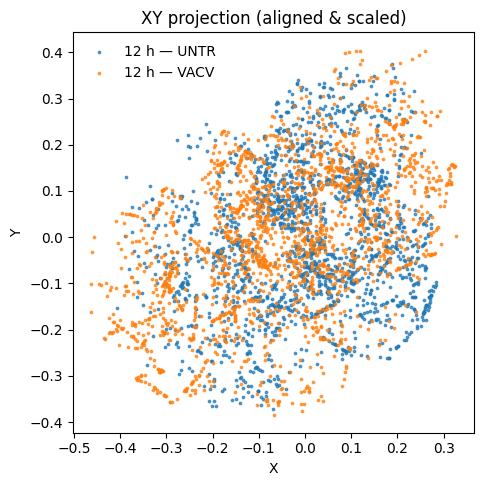

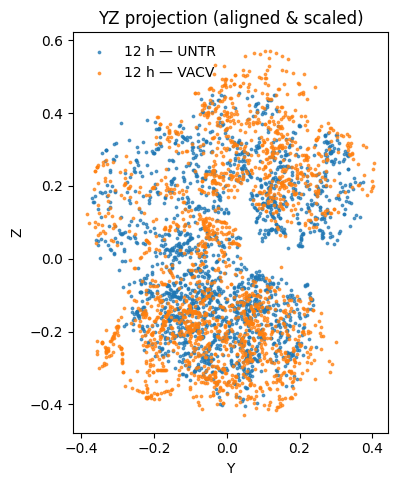

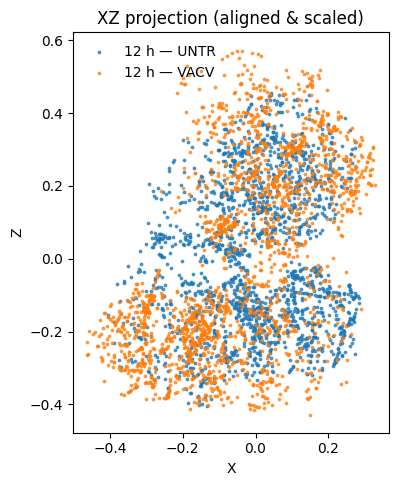

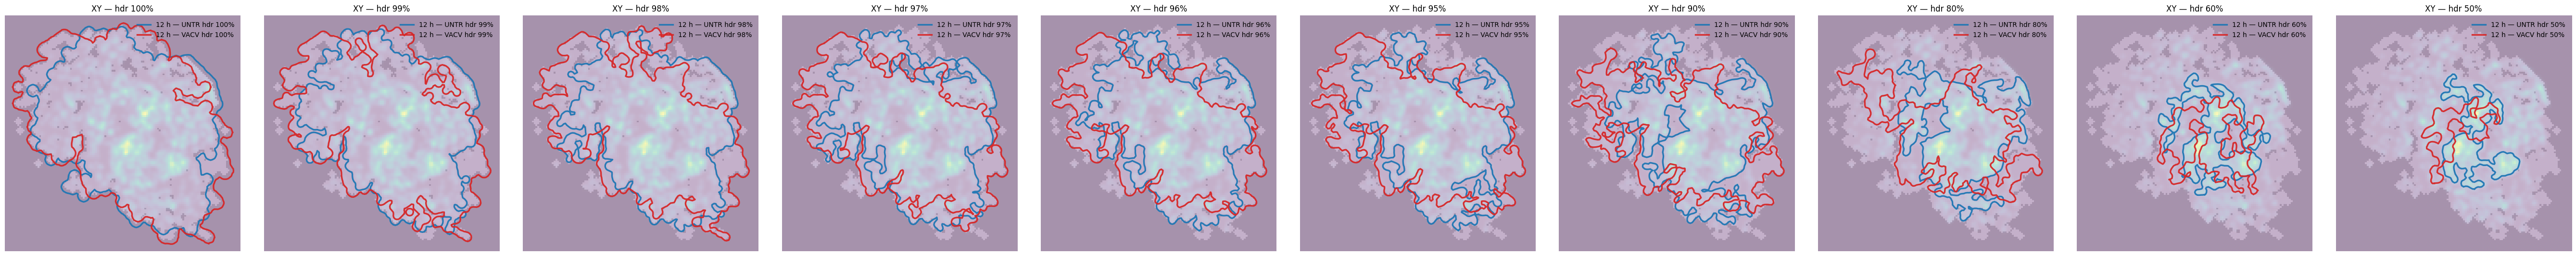

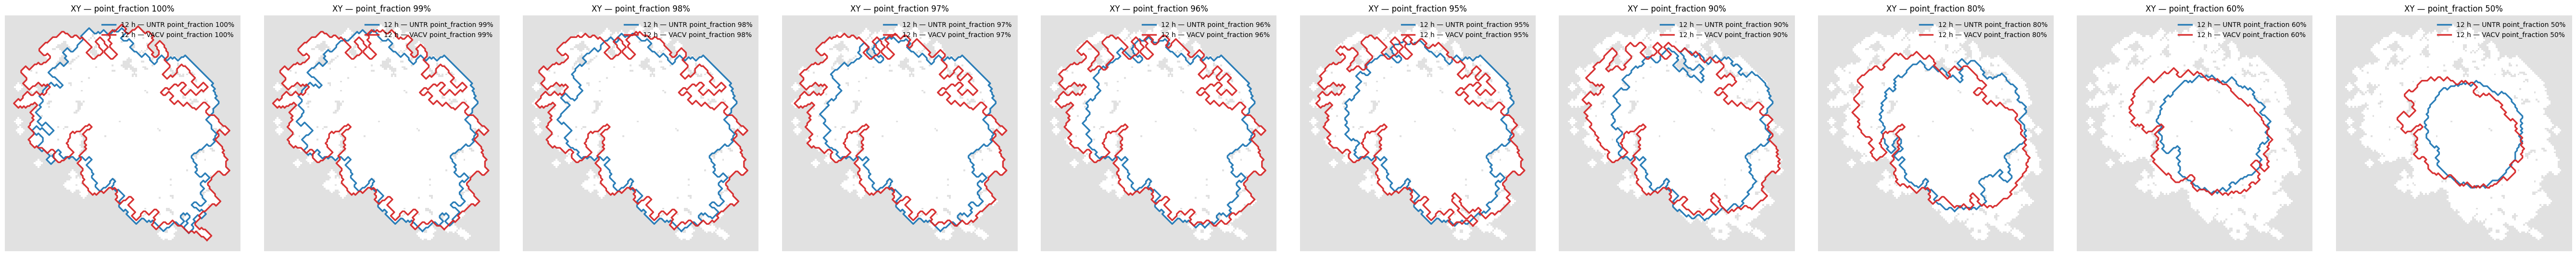

In [3]:
csv_A = "data/green_monkey/all_structure_files/chr1/12hrs/untr/structure_12hrs_untr_gene_info.csv"
csv_B = "data/green_monkey/all_structure_files/chr1/12hrs/vacv/structure_12hrs_vacv_gene_info.csv"
out_dir = "data/green_monkey/va_testing/out_silhouttes_unified"

# ---- Configs ----
cfg_common = CfgCommon(grid_base=160, pad_frac=0.05)

# Reproducible bootstrap, same mass levels as before (includes 100)
# Tip: remove 1.00 from mass_levels if you don't want HDR level=100 in outputs.
cfg_hdr = CfgHDR(n_boot=256, rng_seed=0)
# cfg_hdr = CfgHDR(n_boot=256, rng_seed=0,
#                  mass_levels=(0.99, 0.98, 0.97, 0.96, 0.95, 0.90, 0.80, 0.60, 0.50))

# PF with exposed morphology knobs (defaults match previous behavior)
cfg_pf = CfgPF(
    disk_px=2,
    bandwidth=None,  # auto bandwidth (median*0.5)
    # morph=CfgMorph(closing=2, opening=0, keep_largest=True, fill_holes=True)  # optional tweak
)

# ---- Run pipeline ----
res = run_silhouettes(
    csv_A=csv_A,
    csv_B=csv_B,
    # xyz_cols=("middle_x","middle_y","middle_z"),  # defaults already match our CSVs
    out_dir=out_dir,
    run_hdr=True, run_pf=True,
    cfg_common=cfg_common,
    cfg_hdr=cfg_hdr,
    cfg_pf=cfg_pf,
    planes=("XY","YZ","XZ"),  # you can subset, e.g., ("XY","YZ")
)

print(res["metrics"].head())

view_projections(res,
                 planes=("XY","YZ","XZ"),
                 labelA="12 h — UNTR",
                 labelB="12 h — VACV")

save_projections(res,
                 out_dir=out_dir,
                 planes=("XY","YZ","XZ"),
                 labelA="12 h — UNTR",
                 labelB="12 h — VACV",
                 save_csv=True)

# ---- View (interactive) ----
# HDR (with A's density heat)
view(res, kind="hdr", plane="XY", levels="all",
     show_heat=True, labelA="12 h — UNTR", labelB="12 h — VACV")

# PF (all levels for XY)
view(res, kind="point_fraction", plane="XY", levels="all",
     labelA="12 h — UNTR", labelB="12 h — VACV")
# Or a subset:
# view(res, kind="point_fraction", plane="XY", levels=[100,95,80],
#      labelA="12 h — UNTR", labelB="12 h — VACV")

# ---- Save figures (to files) ----
# Save HDR overlays for all levels on XY
save_figures(res, kind="hdr", plane="XY", levels="all",
             out_dir=out_dir, show_heat=True,
             labelA="12 h — UNTR", labelB="12 h — VACV")

# Save PF overlays at 95% and 50% for YZ
save_figures(res, kind="point_fraction", plane="YZ", levels=[95, 50],
             out_dir=out_dir,
             labelA="12 h — UNTR", labelB="12 h — VACV")



In [4]:
# then export everything as pure data
export_all(res, out_dir="data/green_monkey/va_testing/web_data",
           include_density=True,
           kind_levels={"hdr":"all", "point_fraction":"all"})

/tmp/ipykernel_5961/1052129145.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


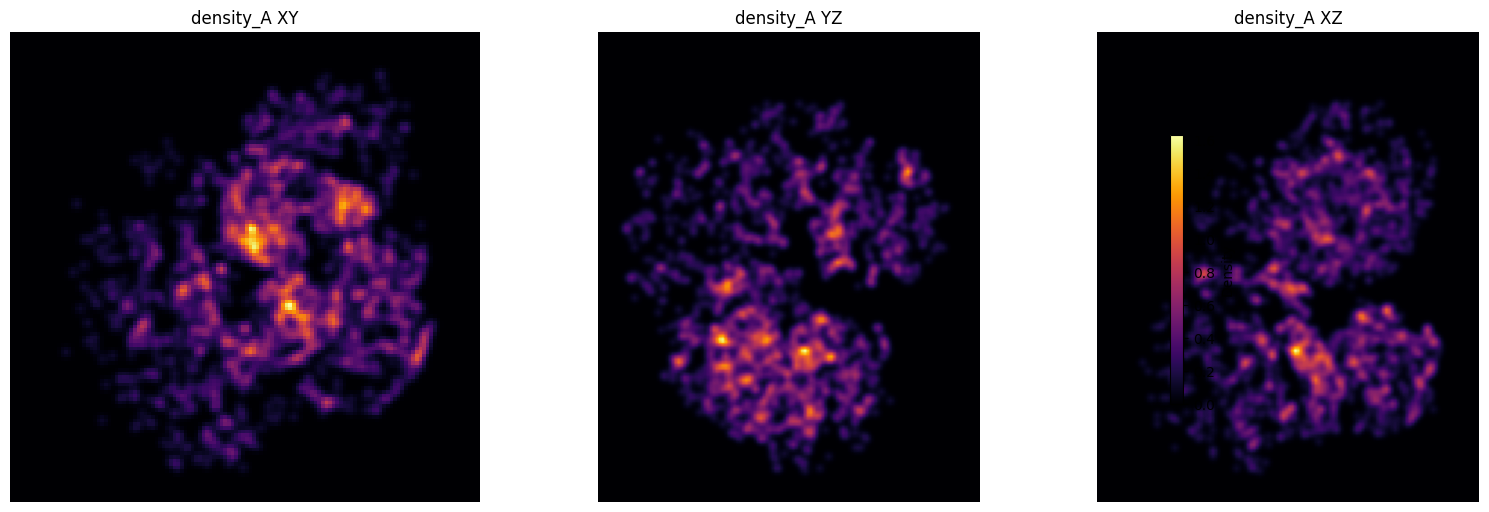

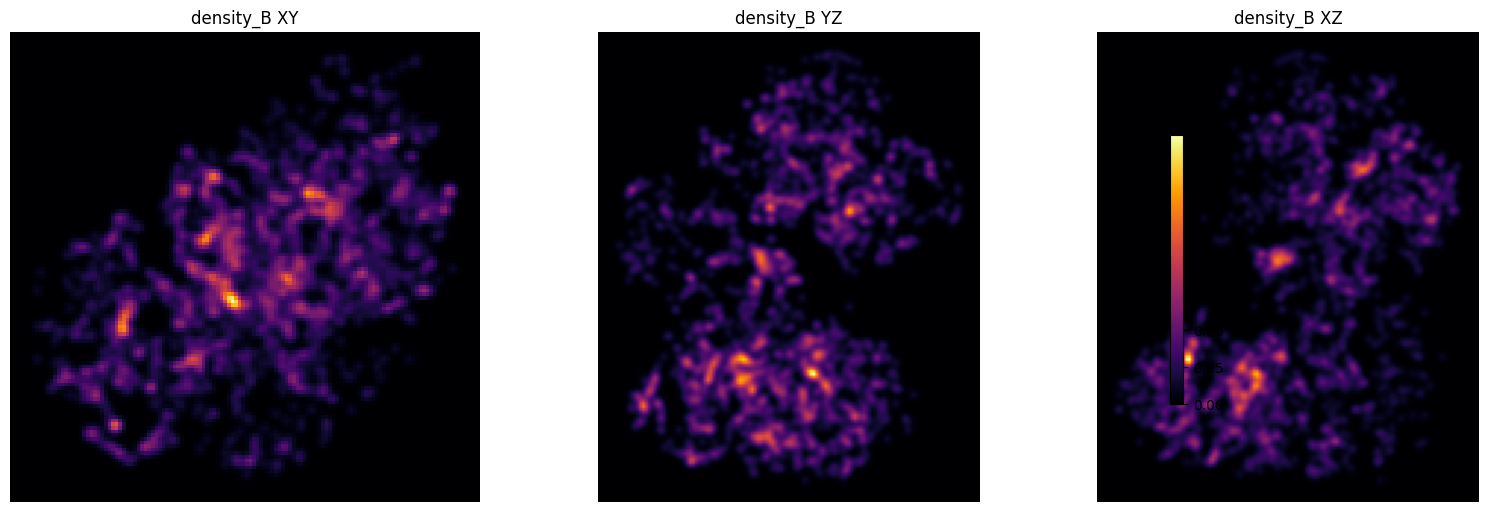

In [9]:
# # from silhouette_core import (
# #     run_silhouettes, CfgCommon, CfgHDR, CfgPF, CfgMorph,
# #     view, save_figures, save_projections
# # )

# csv_A = "data/green_monkey/all_structure_files/chr1/12hrs/untr/structure_12hrs_untr_gene_info.csv"
# csv_B = "data/green_monkey/all_structure_files/chr1/12hrs/vacv/structure_12hrs_vacv_gene_info.csv"
# out_dir = "data/green_monkey/va_testing/out_silhouttes_unified"

# # ---------- Configs (all fields) ----------
# cfg_common = CfgCommon(
#     grid_base=160,     # target longest grid side (32..512 after clipping)
#     pad_frac=0.05,     # padding added around bbox
#     trim_q=0.10,       # ICP: trim worst fraction per iter (0..0.5)
#     icp_iters=30,      # ICP iterations
#     sample_icp=50000,  # ICP sample cap
#     out_dir=out_dir
# )

# cfg_hdr = CfgHDR(
#     n_boot=256,                # bootstrap resamples
#     sample_frac=1.0,           # frac of points per resample (with replacement)
#     sigma_px=1.2,              # Gaussian blur in pixels
#     density_floor_frac=0.002,  # zero-out tiny densities before thresholding
#     mass_levels=(1.00, 0.99, 0.98, 0.97, 0.96, 0.95, 0.90, 0.80, 0.60, 0.50),
#     rng_seed=0                 # reproducible bootstrap
# )

# cfg_pf = CfgPF(
#     frac_levels=(1.00, 0.99, 0.98, 0.97, 0.96, 0.95, 0.90, 0.80, 0.60, 0.50),
#     bandwidth=None,  # auto (median distance * 0.5)
#     disk_px=2,
#     morph=CfgMorph(
#         closing=1,        # morphological closing iters
#         opening=1,        # morphological opening iters
#         keep_largest=True,
#         fill_holes=True
#     )
# )

# # ---------- Run ----------
# res = run_silhouettes(
#     csv_A=csv_A,
#     csv_B=csv_B,
#     A_points=None, B_points=None,                 # (optional) pass arrays instead of CSVs
#     xyz_cols=("middle_x","middle_y","middle_z"),  # column names in CSVs
#     out_dir=out_dir,
#     run_hdr=True,
#     run_pf=True,
#     cfg_common=cfg_common,
#     cfg_hdr=cfg_hdr,
#     cfg_pf=cfg_pf,
#     planes=("XY","YZ","XZ")                       # subset if you like, e.g. ("XY","YZ")
# )

# print(res["metrics"].head())

# # ---------- Save raw 2D projections after alignment ----------
# save_projections(
#     res,
#     out_dir=out_dir,
#     planes=("XY","YZ","XZ"),
#     labelA="12 h — UNTR",
#     labelB="12 h — VACV",
#     s=3.0,
#     alphaA=0.7,
#     alphaB=0.7,
#     dpi=220,
#     save_csv=False   # set True to export projection_A.csv / projection_B.csv per plane
# )

# # ---------- View overlays ----------
# view(
#     res,
#     kind="hdr",                   # 'hdr' | 'point_fraction'
#     plane="XY",                   # 'XY' | 'YZ' | 'XZ'
#     levels="all",                 # int | [ints] | "all"
#     labelA="12 h — UNTR",
#     labelB="12 h — VACV",
#     show_heat=True,               # show A's density heat for HDR
#     cfg_hdr=cfg_hdr,              # (optional) only used to parse "all"
#     cfg_pf=cfg_pf
# )

# view(
#     res,
#     kind="point_fraction",
#     plane="XY",
#     levels="all",
#     labelA="12 h — UNTR",
#     labelB="12 h — VACV",
#     show_heat=False,
#     cfg_hdr=cfg_hdr,
#     cfg_pf=cfg_pf
# )

# # ---------- Save overlay figures ----------
# save_figures(
#     res,
#     kind="hdr",
#     plane="XY",
#     levels="all",
#     out_dir=out_dir,
#     labelA="12 h — UNTR",
#     labelB="12 h — VACV",
#     show_heat=True,
#     cfg_hdr=cfg_hdr,
#     cfg_pf=cfg_pf
# )

# save_figures(
#     res,
#     kind="point_fraction",
#     plane="YZ",
#     levels=[95, 50],
#     out_dir=out_dir,
#     labelA="12 h — UNTR",
#     labelB="12 h — VACV",
#     show_heat=False,
#     cfg_hdr=cfg_hdr,
#     cfg_pf=cfg_pf
# )

# # ---------- Export full bundle for D3 + Three.js ----------
# from silhouette_exporters import export_all  

# export_all(
#     res,                              # the RunResult from run_silhouettes
#     out_dir=out_dir,                  # same output directory
#     include_density=True,             # include density_A.json / density_B.json
#     export_layout=True,               # include layout.json (for 3D slice placement)
#     export_scales=True,               # include scales.json (global bounding box)
#     kind_levels={"hdr": "all",        # which HDR levels to export ("all" or list of ints)
#                  "point_fraction": "all"}
# )

# This produces:
#   meta.json
#   background_mask.json
#   density_A.json / density_B.json     (if include_density=True)
#   contours_d3.json
#   projections.json
#   metrics.json
#   points3d.json
#   layout.json                         (if export_layout=True)
#   scales.json                         (if export_scales=True)

